<a href="https://colab.research.google.com/github/mystlee/2024_CSU_AI/blob/main/chapter8/example_source_separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install speechbrain torchaudio huggingface_hub matplotlib datasets -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 23.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from speechbrain.inference.separation import SepformerSeparation as separator
import torchaudio
from datasets import load_dataset
from transformers import pipeline
from IPython.display import Audio
import torch
import librosa
from datasets import load_dataset
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    sample_file_path = filename

Saving test_mixture.wav to test_mixture.wav


In [ ]:
model = separator.from_hparams(source = "speechbrain/sepformer-wsj02mix",
                               savedir = 'pretrained_models/sepformer-wsj02mix')

# for custom file, change path
est_sources = model.separate_file(sample_file_path)
src1_path = "source1.wav"
src2_path = "source2.wav"
torchaudio.save(src1_path, est_sources[:, :, 0].detach().cpu(), 8000)
torchaudio.save(src2_path, est_sources[:, :, 1].detach().cpu(), 8000)

In [ ]:
print("mixture")
display(Audio(sample_file_path))
print("\nestimated source 1")
display(Audio(src1_path))
print("\nestimated source 2")
display(Audio(src2_path))

mixture



estimated source 1



estimated source 2


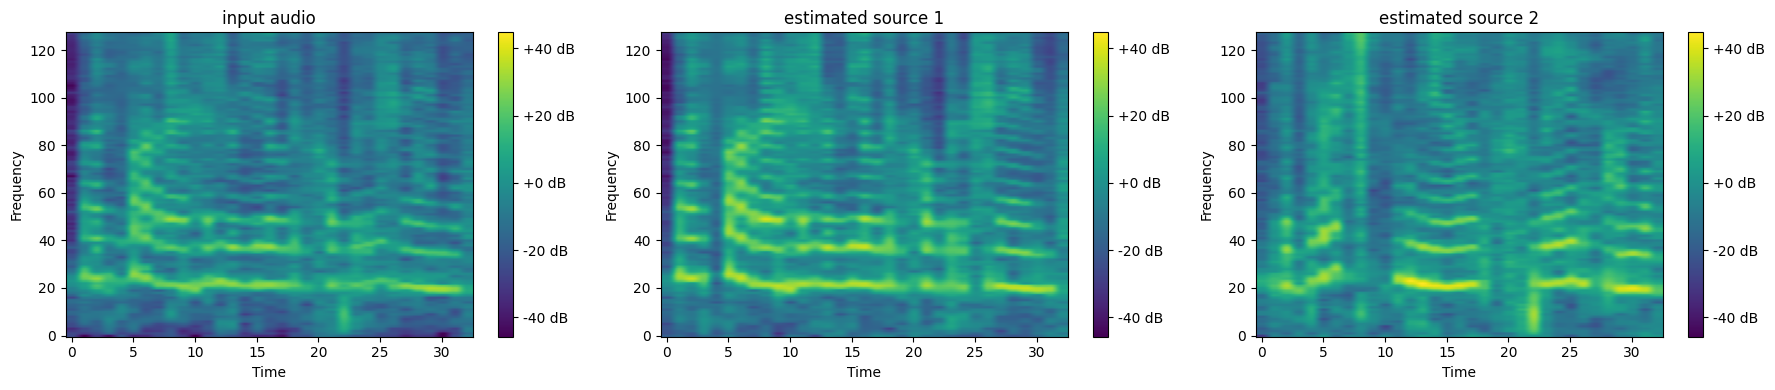

In [ ]:
mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate = 16000,
        n_fft = 1024,
        hop_length = 512,
        n_mels = 128)

signal_orig, sr_orig = torchaudio.load(sample_file_path)
if signal_orig.shape[0] > 1:
    signal_orig = torch.mean(signal_orig, dim = 0, keepdim = True)

src1, sr = torchaudio.load(src1_path)
if src1.shape[0] > 1:
    src1 = torch.mean(src1, dim = 0, keepdim = True)
src2, sr = torchaudio.load(src2_path)
if src2.shape[0] > 1:
    src2 = torch.mean(src2, dim = 0, keepdim = True)

mel_orig = mel_spectrogram_transform(signal_orig)
mel_src1 = mel_spectrogram_transform(src1)
mel_src2 = mel_spectrogram_transform(src2)

mel_orig_db = torchaudio.transforms.AmplitudeToDB()(mel_orig)
mel_src1_db = torchaudio.transforms.AmplitudeToDB()(mel_src1)
mel_src2_db = torchaudio.transforms.AmplitudeToDB()(mel_src2)

mel_orig_db_np = mel_orig_db.squeeze().numpy()
mel_src1_db_np = mel_src1_db.squeeze().numpy()
mel_src2_db_np = mel_src2_db.squeeze().numpy()

global_min = min(mel_orig_db.min().item(), mel_src1_db_np.min().item(), mel_src2_db_np.min().item())
global_max = max(mel_orig_db.max().item(), mel_src1_db_np.max().item(), mel_src2_db_np.max().item())

fig, axs = plt.subplots(1, 3, figsize = (18, 4))

img1 = axs[0].imshow(mel_orig_db_np, aspect = 'auto',
                     origin = 'lower', cmap = 'viridis',
                     vmin = global_min, vmax = global_max)
axs[0].set_title('input audio')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')
fig.colorbar(img1, ax = axs[0], format = "%+2.f dB")

img2 = axs[1].imshow(mel_src1_db_np, aspect = 'auto',
                     origin = 'lower', cmap = 'viridis',
                     vmin = global_min, vmax = global_max)
axs[1].set_title('estimated source 1')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')
fig.colorbar(img2, ax = axs[1], format = "%+2.f dB")

img3 = axs[2].imshow(mel_src2_db_np, aspect = 'auto',
                     origin = 'lower', cmap = 'viridis',
                     vmin = global_min, vmax = global_max)
axs[2].set_title('estimated source 2')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Frequency')
fig.colorbar(img3, ax = axs[2], format = "%+2.f dB")

plt.tight_layout()
plt.show()

In [ ]:
from huggingface_hub import hf_hub_download
repo_id = "speechbrain/sepformer-wsj02mix"
filename = "speechbrain/sepformer-wsj02mix/test_mixture.wav"
try:
    sample_file_path = hf_hub_download(repo_id=repo_id, filename=filename)
    print(f"예제 파일이 다운로드되었습니다: {sample_file_path}")
except Exception as e:
    print("파일 다운로드 중 오류 발생:", e)

파일 다운로드 중 오류 발생: 404 Client Error. (Request ID: Root=1-6755ee1c-5d9650bb65d1272b3d246545;e05a884d-b310-42a7-a403-1959b3279214)

Entry Not Found for url: https://huggingface.co/speechbrain/sepformer-wsj02mix/resolve/main/speechbrain/sepformer-wsj02mix/test_mixture.wav.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
